In [3]:
import importlib
from joblib import Parallel, delayed, cpu_count

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import Modules.read_data_from_cluster as rfc
import Modules.pade_fits as pf
import Modules.figures as figs

plt.rcParams['font.size'] = '16'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = '200'
# plt.rcParams['backend'] = 'ipympl'
%matplotlib ipympl

importlib.reload(rfc)
importlib.reload(pf)
importlib.reload(figs)

color_vs_size = [ 'turquoise',  'tab:olive', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray','tab:blue', 'goldenrod', 'tab:orange', 'tab:red']

color_vs_adj = [ 'turquoise',  'tab:olive', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'goldenrod', 'tab:orange', 'tab:red']

In [4]:
# Simulation parameters to read data
distribution = 'gaussian_EA'
adjacencies = ['random_regular_3', 'random_regular_5', 'random_regular_7', 'random_regular_9',
               '1D+', '1D+', '1D+', '1D+',
               'chimera', 'pegasus', 'zephyr']
add_vs_adj = [0, 0, 0, 0,
              3.0, 5.0, 7.0, 9.0,
              0, 0, 0]
sizes = [100, 200, 400, 800, 1600]
sizes_vs_adj = [_ for _ in range(len(adjacencies))]
for i, adj in enumerate(adjacencies):
    if adj == 'chimera':
        sizes_vs_adj[i] = [72, 200, 392, 800, 1568]
    elif adj == 'pegasus':
        sizes_vs_adj[i] = [128, 256, 448, 960, 1664]
    elif adj == 'zephyr':
        sizes_vs_adj[i] = [48, 160, 336, 576, 1248]
    else:
        sizes_vs_adj[i] = sizes
color_vs_size = ['turquoise',  'tab:olive', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray','tab:blue', 'goldenrod', 'tab:orange', 'tab:red']
marker_vs_adjacency = ['^', '>', 'v', '<', '1', '2', '3', '.', '4', 'P', 'd', '*']


# [Figures 9, 10, 11, 12] Thermalization tests

In [230]:
adj_index = 9  # Pegasus
size_index = 3 # 800

# Load processed data
fname = f'Processed_Data/thermalization_tests_adjacency={adjacencies[adj_index]},size={sizes_vs_adj[adj_index][size_index]}.npz'
data = np.load(fname, allow_pickle=True)
MCS_avg_vs_size = data['MCS_avg_vs_size']
N_configs_vs_size = data['N_configs_vs_size']
T_vs_size = data['T_vs_size']
error_q2_logarithmic_binning = data['error_q2_logarithmic_binning']
error_std_q2_logarithmic_binning = data['error_std_q2_logarithmic_binning']
cluster_link_convergence = data['cluster_link_convergence']
error_q2_vs_T = data['error_q2_vs_T']
tau_q2_vs_T = data['tau_q2_vs_T']
bins = data['bins']
q_dist_vs_T = data['q_dist_vs_T']

## [Figure 9] Thermalization test 1 - Logarithmic binning method

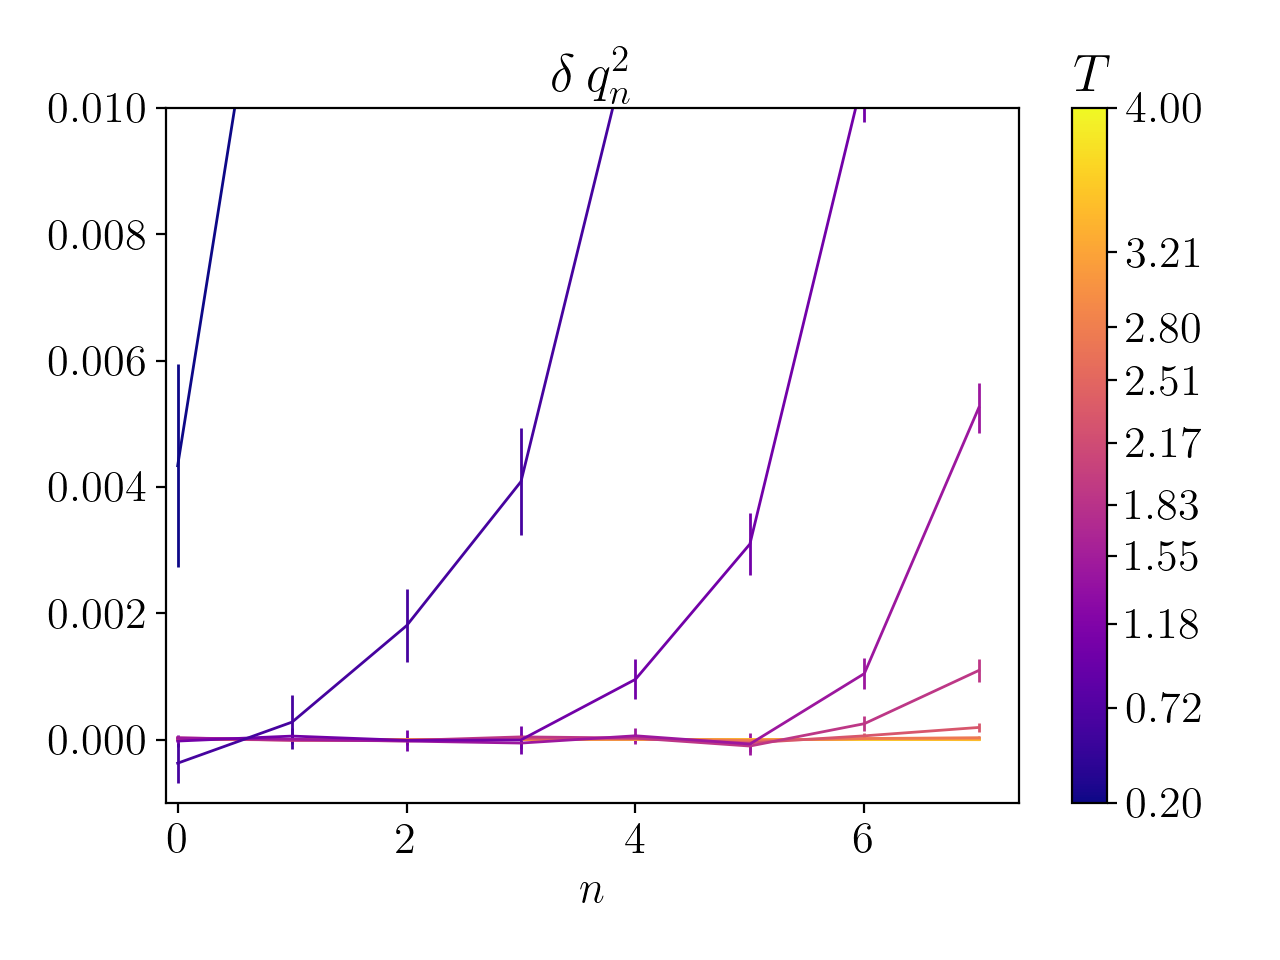

In [231]:
# Define temperatures for the plots
copies = len(T_vs_size[size_index][-1])
n_MCS = len(MCS_avg_vs_size[size_index])

T_indices = np.linspace(0, copies-1, 10, dtype='int')
colors = plt.get_cmap('plasma')(np.linspace(0, 255, 10).astype('int'))

fig, ax = plt.subplots(dpi=200)
for T_index in T_indices[::-1]:
    ax.errorbar(np.arange(n_MCS - 1), error_q2_logarithmic_binning[::-1, T_index],
                yerr=error_std_q2_logarithmic_binning[::-1, T_index] / np.sqrt(N_configs_vs_size[size_index][-1]),
                color=colors[np.where(T_index == T_indices)[0][0]], linewidth=1)
ax.set_title(r'$\delta \: q^2_n$')
ax.set_xlabel(r'$n$')
ax.set_ylim([-0.001, 0.01])
ax.set_xlim(left=-0.1)
figs.colorbar_for_lines(fig, T_vs_size[size_index][-1][T_indices].round(2), label='$T$', location='top')
fig.tight_layout()
figs.export(f'thermalization_test_1_logarithmic_binning_q2_adjacency={adjacencies[adj_index]},size={sizes_vs_adj[adj_index][size_index]}.pdf')

## [Figure 10] Thermalization test 2 - Cluster link overlap

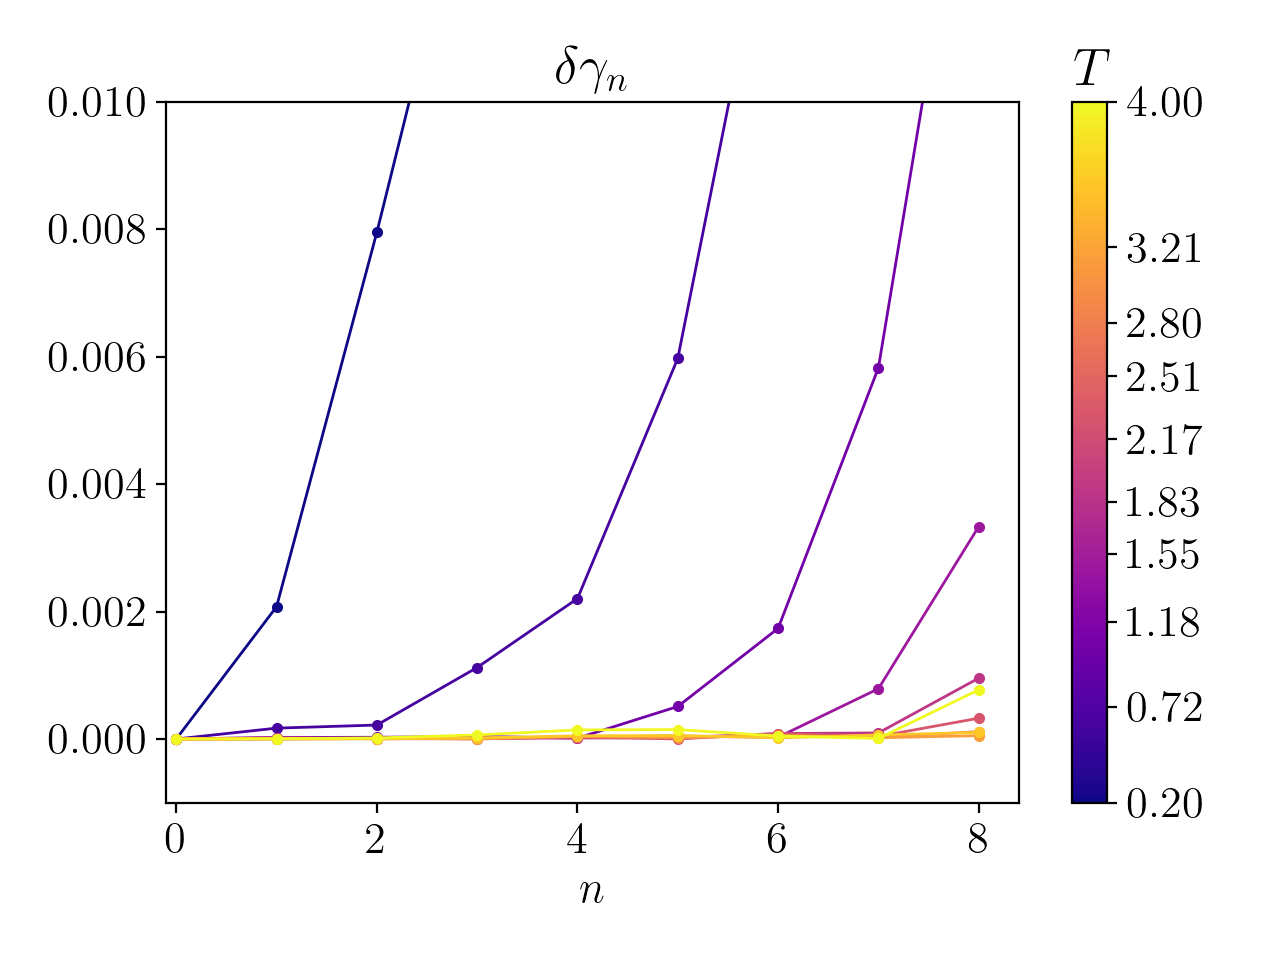

In [232]:
# Define temperatures for the plots
fig, ax = plt.subplots(dpi=200)
for T_index in T_indices:
    ax.plot(np.arange(n_MCS), np.abs(cluster_link_convergence[-1, T_index]- cluster_link_convergence[::-1, T_index]), '.-',
            color=colors[np.where(T_index == T_indices)[0][0]], linewidth=1)
ax.set_ylim([-0.001, 0.01])
ax.set_xlim(left=-0.1)
ax.set_title(r'$\delta \gamma_{n}$')
ax.set_xlabel(r'$n$')
# ax.set_title(fr'$1-T|U|/c -q_l$')
figs.colorbar_for_lines(fig, T_vs_size[size_index][-1][T_indices].round(2), label='$T$', location='top')
fig.tight_layout()
figs.export(f'thermalization_test_2_cluster_link_adjacency={adjacencies[adj_index]},size={sizes_vs_adj[adj_index][size_index]}.pdf')

## [Figure 11] Thermalization test 3 - Autocorrelation time and thermal average error of q2

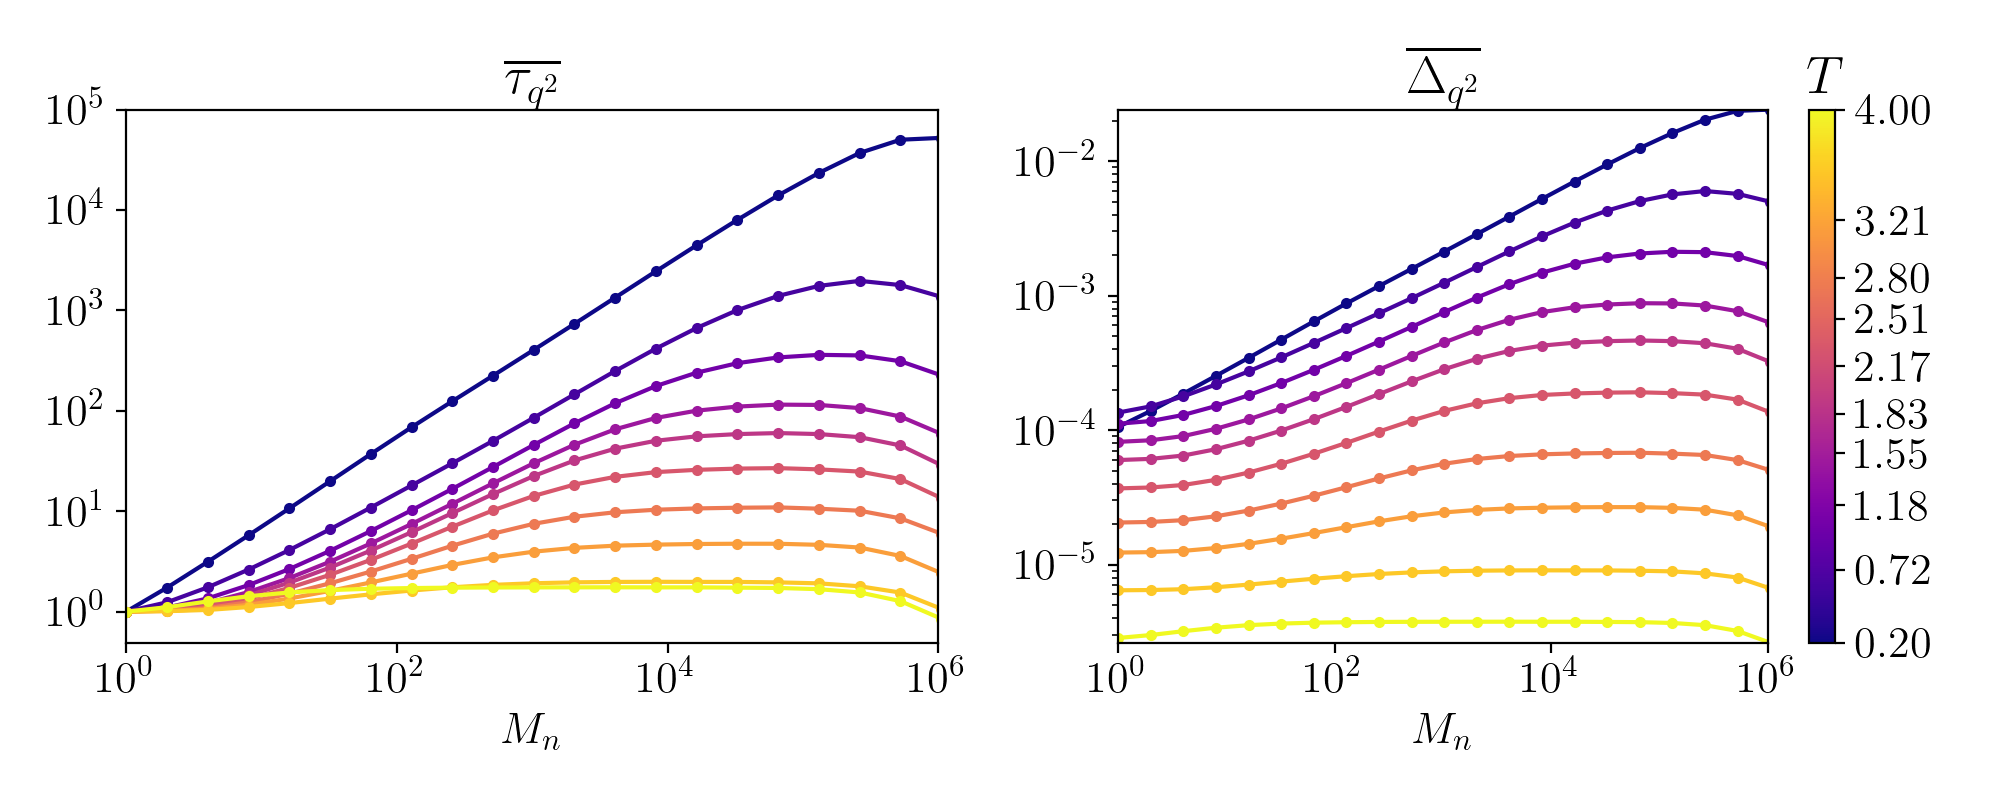

In [233]:
fig, (ax2, ax1) = plt.subplots(ncols=2, figsize=[10, 4])
for T_index in range(copies):
    if np.any(T_index == T_indices):
        ax1.plot(2 ** bins, error_q2_vs_T[T_index], '.-', color=colors[np.where(T_index == T_indices)[0][0]])
        ax2.plot(2 ** bins, tau_q2_vs_T[T_index], '.-', color=colors[np.where(T_index == T_indices)[0][0]])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title(r'$\overline{\Delta_{q^2}}$')
ax1.set_xlabel(r'$M_n$')
ax1.set_xlim([1, 1e6])

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title(r'$\overline{\tau_{q^2}}$')
ax2.set_xlabel(r'$M_n$')
ax2.set_xlim([1, 1e6])
ax2.set_yticks([1e0,1e1,1e2,1e3,1e4,1e5])

figs.colorbar_for_lines(fig, T_vs_size[size_index][0][T_indices].round(2), label='$T$', location='top')
fig.tight_layout()
figs.export(f'thermalization_test_3_autocorrelation_time_and_thermalization_error_adjacency={adjacencies[adj_index]},size={sizes_vs_adj[adj_index][size_index]}.pdf')


## [Figure 12] Thermalization test 4 - P(q)

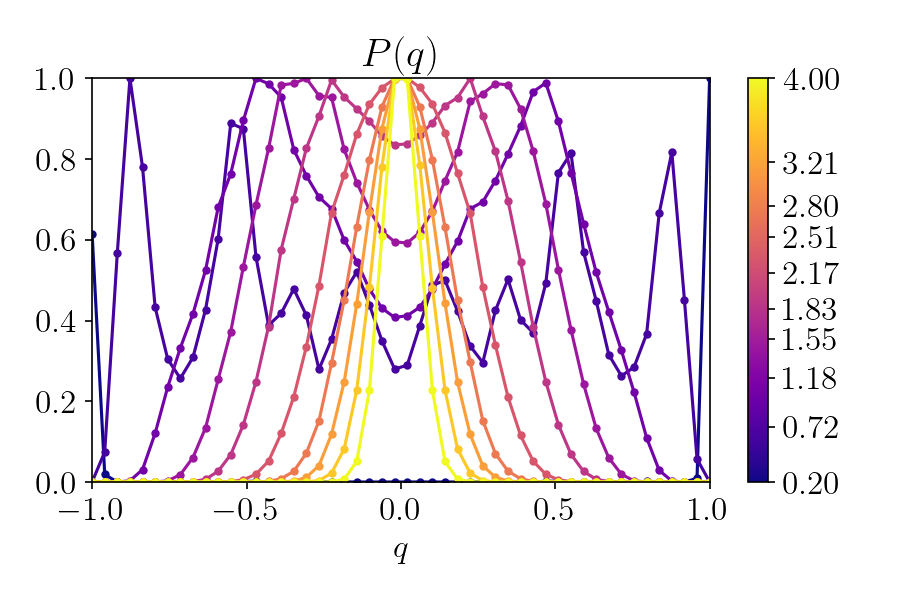

In [234]:
dist = np.linspace(-1, 1, 50)
fig1, ax1 = plt.subplots(ncols=1, figsize=[6, 4], dpi=150)
for T_index in range(copies):
    if np.any(T_index == T_indices):
        ax1.plot(dist, q_dist_vs_T[:,T_index], '.-', color=colors[np.where(T_index == T_indices)[0][0]])
ax1.set_title(r'$P(q)$')
ax1.set_xlabel(r'$q$')
figs.colorbar_for_lines(fig1, T_vs_size[size_index][0][T_indices].round(2))
fig1.tight_layout()
figs.export(f'thermalization_test_4_probability_distribution_q_adjacency={adjacencies[adj_index]},size={sizes_vs_adj[adj_index][size_index]}.pdf')

# [Figures 2 and 5] Binder cumulant and derivative with padé approximants

In [9]:
MCS_N_config_condition = 'max_MCS_with_a_minimum_of_N_configs'
min_N_config = 1000
adj_index = 2 # Use 0 for fig. 2 and 10 for fig. 5

In [10]:
# Load calculated data
fname = f'Processed_Data/g_and_g_pade_and_dg_dT_inset_adj={adjacencies[adj_index]}_add={add_vs_adj[adj_index]}_' \
        f'read_mode={MCS_N_config_condition}_min_N_config={min_N_config}.npz'
data = np.load(fname, allow_pickle=True)
T_vs_size_best = data['T_vs_size_best']
g_vs_size_best = data['g_vs_size_best']
error_vs_size_best = data['error_vs_size_best']
dg_dT_vs_size_best = data['dg_dT_vs_size_best']
error_dg_dT_vs_size_best = data['error_dg_dT_vs_size_best']
T_c = data['T_c']
T_pade = data['T_pade']
dg_dT_pade_array = data['dg_dT_pade_array']
peak_height = data['peak_height']

/tmp/ipykernel_8428/2650834886.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


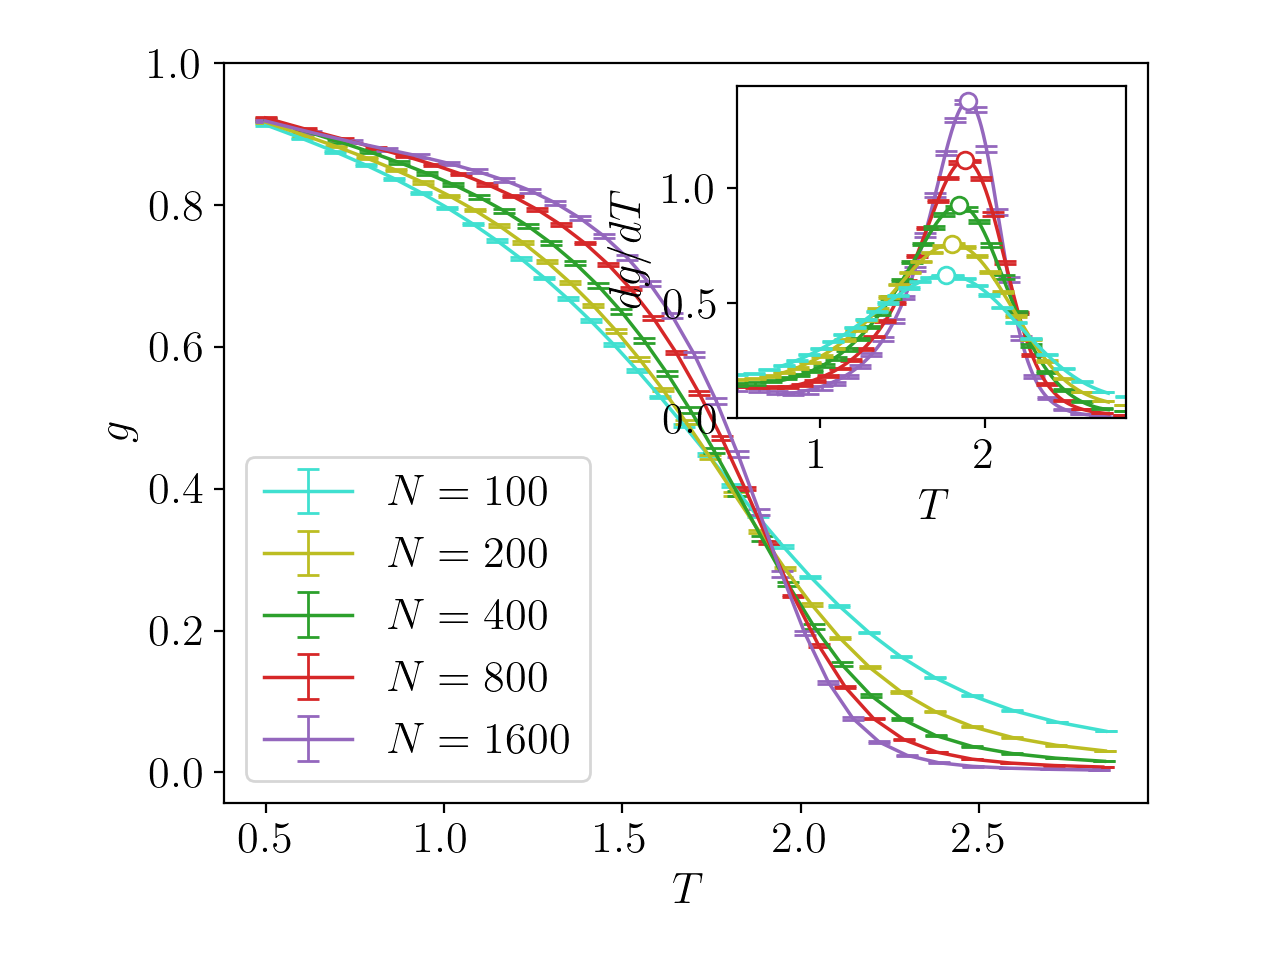

In [11]:
# Set figure parameters
aspect_ratio_g_and_dg_dT = 1
aspect_ratio_fits =  0.8
T0 = T_vs_size_best[0]
Tf = T_vs_size_best[-1]

# Plot binder cumulant with errors
fig, ax = plt.subplots()
for size_index in range(len(sizes)):
    ax.errorbar(T_vs_size_best[size_index], g_vs_size_best[size_index], yerr=error_vs_size_best[size_index], markerfacecolor="None", capsize=4, capthick=1,
                 elinewidth=1, label=f'$N=\;${sizes_vs_adj[adj_index][size_index]}', color=color_vs_size[size_index],linewidth=1.25)
ax.set_xlabel('$T$')
ax.set_ylabel("$g$")

# Plot derivative of binder cumulant with errors and pade fits
axins = inset_axes(ax, width="42%", height="45%", loc=1)
for size_index in reversed(range(len(sizes))):
    axins.errorbar(T_vs_size_best[size_index], -dg_dT_vs_size_best[size_index], yerr=error_dg_dT_vs_size_best[size_index],
                   linewidth=0, markerfacecolor="None", capsize=4, capthick=1,
                 elinewidth=1, color=color_vs_size[size_index])
    axins.plot(T_pade, -dg_dT_pade_array[size_index], color=color_vs_size[size_index],linewidth=1.25)
    axins.plot(T_c[size_index], -peak_height[size_index], 'o', color=color_vs_size[size_index], markerfacecolor='white',linewidth=1.25)
axins.set_xlabel('$T$')
# axins.set_ylabel("$dg/dT$", loc='top')
axins.set_ylabel("$dg/dT$")


ax.legend(loc='lower left')
ax.set_box_aspect(aspect_ratio_fits)
# ax.set_xlim([0.4, 1])
ax.set_ylim(top=1)
# axins.set_xlim([0.4, 1])
axins.set_ylim([0,  -peak_height[-1]*1.05 ])
# axins.set_yticks([0, 1, 2, 3])
# axins.set_xticks([0.4, 0.6,0.8,1])
fig.tight_layout()
# fig.show()
figs.export(f'g_and_g_pade_and_dg_dT_inset_adj={adjacencies[adj_index]}.pdf')

# [Figure 3] Finite size scaling of the characteristics of the derivative of the binder cumulant

In [18]:
MCS_N_config_condition = 'max_MCS_with_a_minimum_of_N_configs'
min_N_config = 1000
adj_index = 3 # Use 0 for fig. 2 and 10 for fig. 5

In [19]:
# Load calculated data
fname = f'Processed_Data/fss_dg_dT_adj={adjacencies[adj_index]}_add={add_vs_adj[adj_index]}' \
        f'_read_mode={MCS_N_config_condition}_min_N_config={min_N_config}.npz'
data = np.load(fname, allow_pickle=True)

Tc = data['Tc']
Tc_err = data['Tc_err']
inv_peak_height = data['inv_peak_height']
inv_peak_height_err = data['inv_peak_height_err']
peak_width = data['peak_width']
peak_width_err = data['peak_width_err']
Tc_inf = data['Tc_inf']
Tc_inf_err = data['Tc_inf_err']
inv_peak_height_inf = data['inv_peak_height_inf']
inv_peak_height_inf_err = data['inv_peak_height_inf_err']
peak_width_inf = data['peak_width_inf']
peak_width_inf_err = data['peak_width_inf_err']

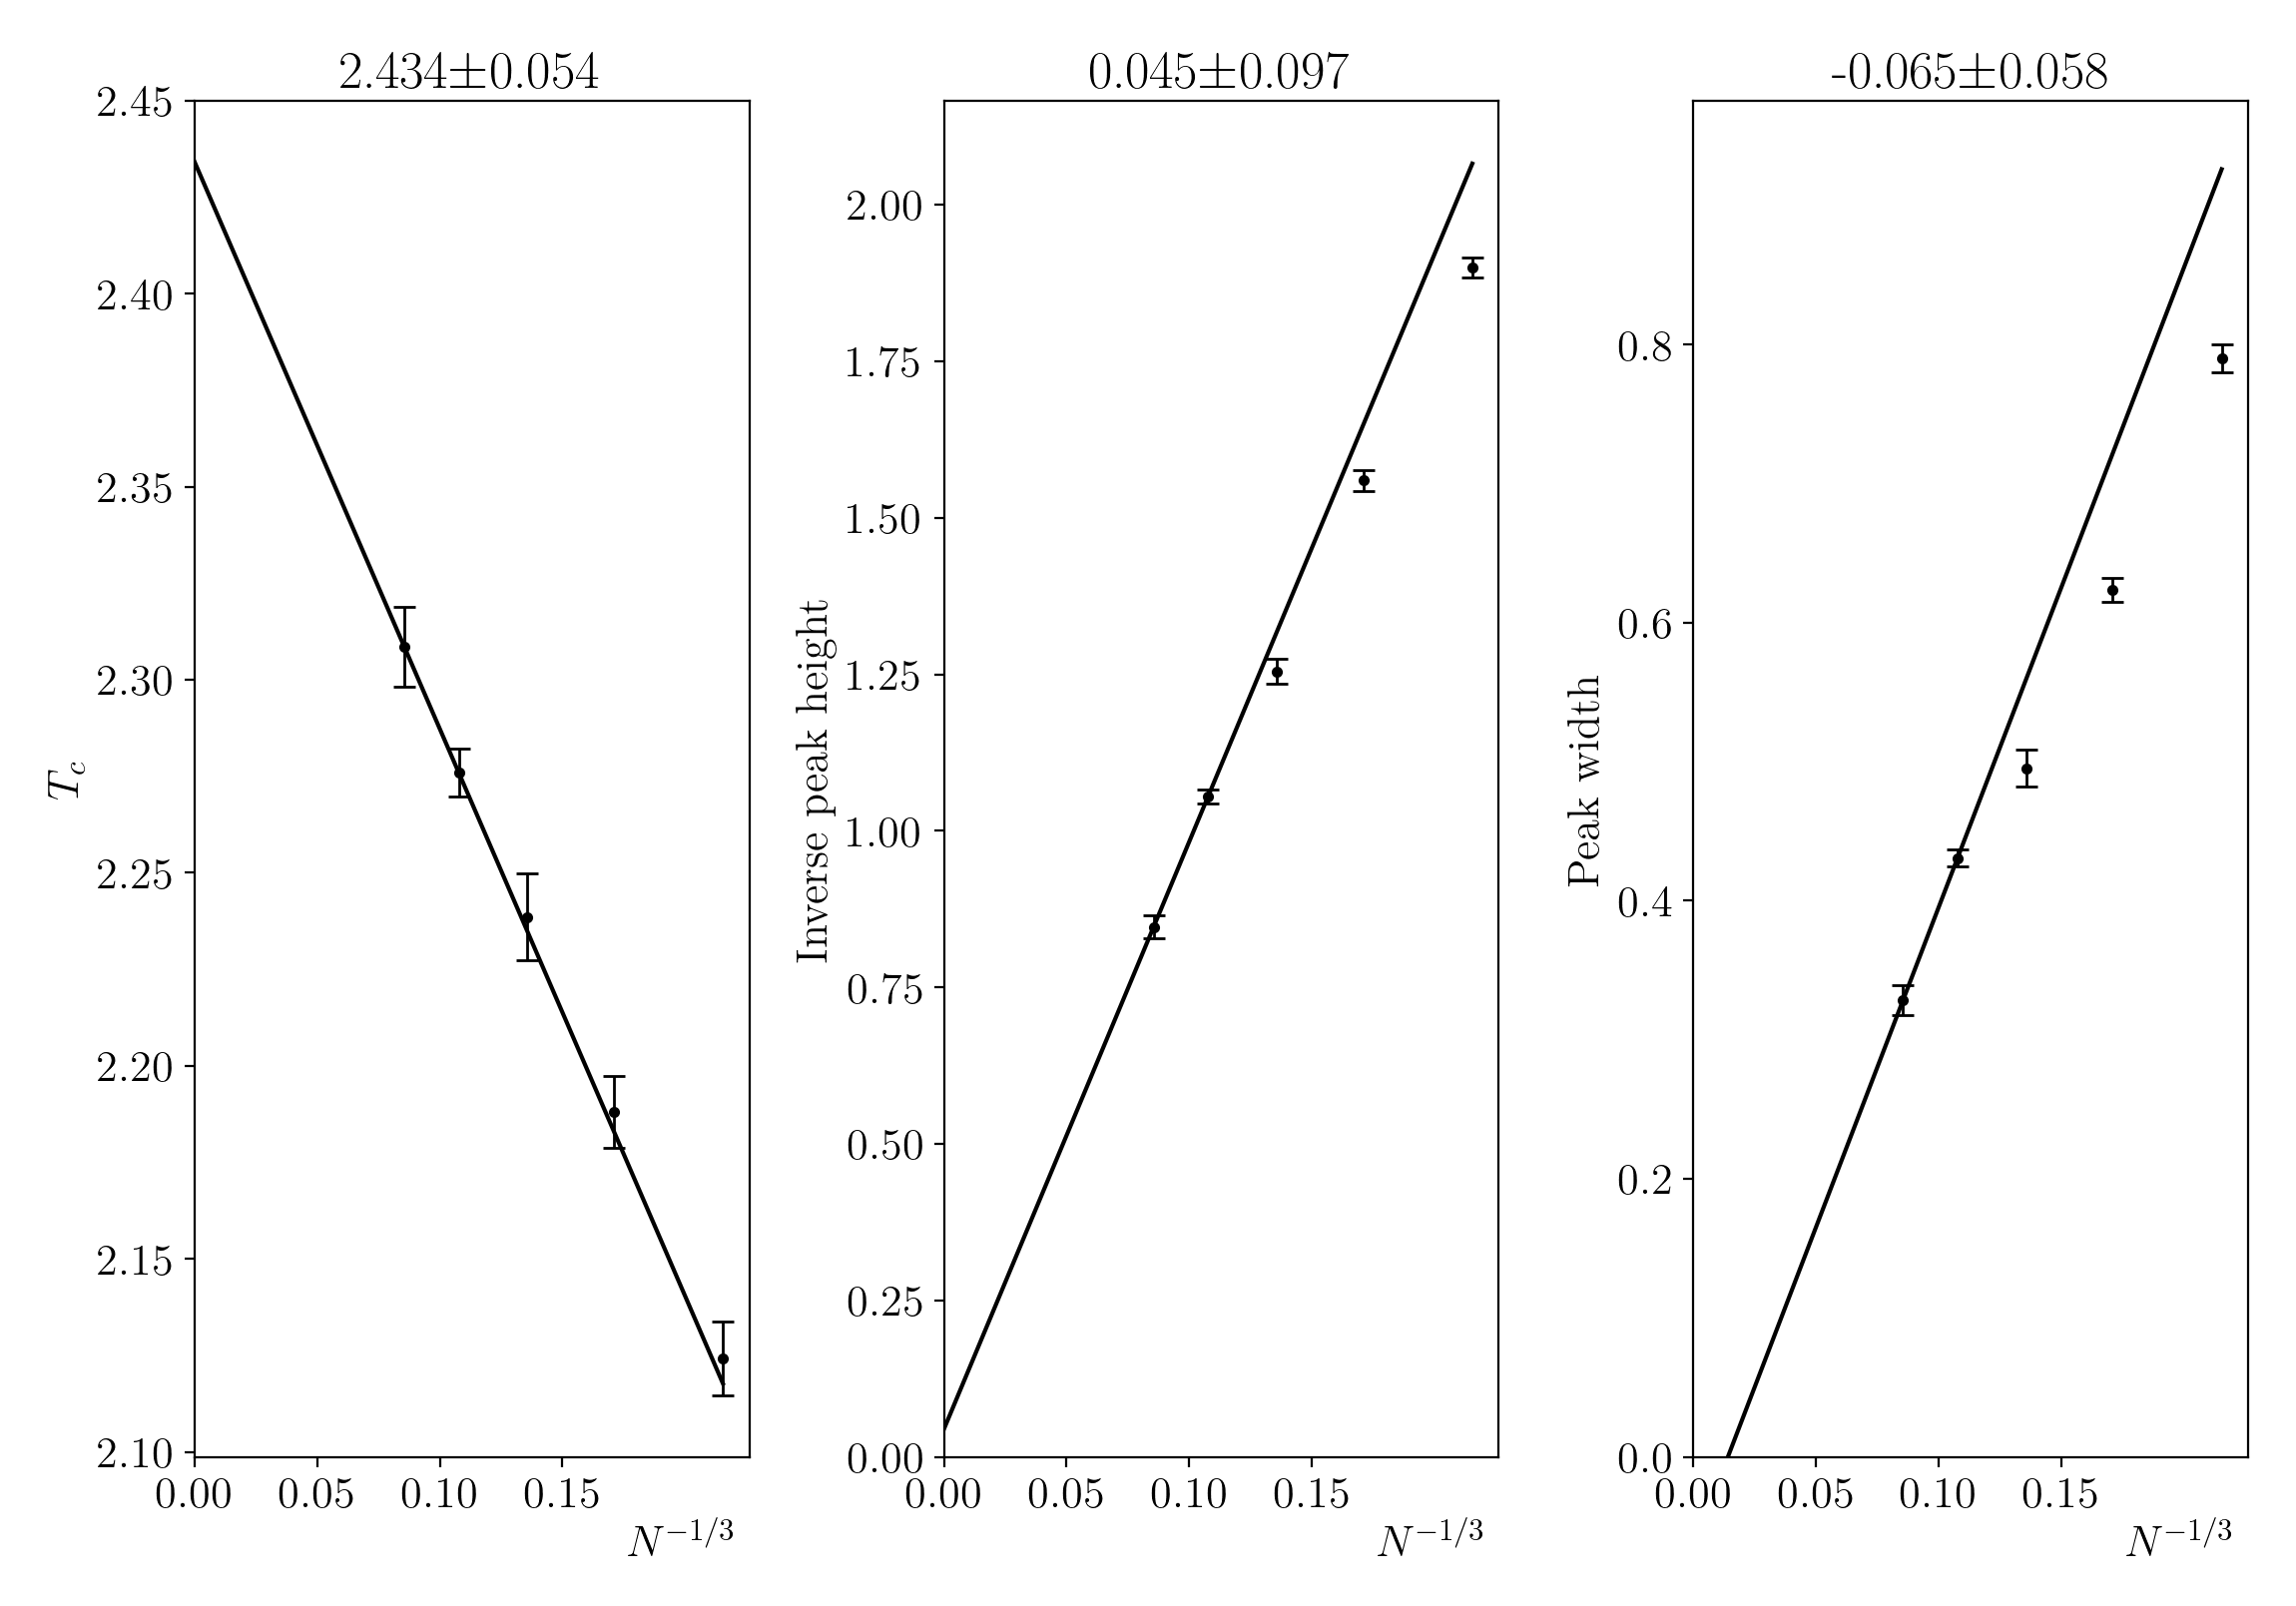

In [20]:
# Plot
figsize_fits = [10*1.15, 7*1.15]
aspect_ratio_fits = 1
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=figsize_fits)

inv_sizes_fit = np.linspace(0, sizes_vs_adj[adj_index][0]**(-1/3), 100)
Tc_fit = np.poly1d(np.polyfit((np.array(sizes_vs_adj[adj_index])**(-1/3))[-2:], Tc[-2:],1))
inv_peak_height_fit = np.poly1d(np.polyfit((np.array(sizes_vs_adj[adj_index])**(-1/3))[-2:], inv_peak_height[-2:],1))
peak_with_fit = np.poly1d(np.polyfit((np.array(sizes_vs_adj[adj_index])**(-1/3))[-2:], peak_width[-2:],1))

ax1.plot(inv_sizes_fit, Tc_fit(inv_sizes_fit), "-", color = 'k')
ax1.set_xlabel('$N^{-1/3}$')
ax1.xaxis.set_label_coords(.88, -0.05)
ax1.set_xticks([0,0.05,0.1,0.15])
ax1.set_xlim(left=0)
ax1.set_ylabel("$T_c$")
ax1.set_title('(a)', y=-.3)

ax2.plot(inv_sizes_fit, -inv_peak_height_fit(inv_sizes_fit), "-", color = 'k')
ax2.set_xlabel('$N^{-1/3}$')
ax2.set_ylabel("Inverse peak height")
ax2.xaxis.set_label_coords(.88, -0.05)
ax2.set_xticks([0,0.05,0.1,0.15])
ax2.set_ylim(bottom=0)
ax2.set_xlim(left=0)
ax2.set_title('(b)', y=-.3)


ax3.plot(inv_sizes_fit, peak_with_fit(inv_sizes_fit), "-", color = 'k')
ax3.set_xlabel('$N^{-1/3}$')
ax3.set_ylabel("Peak width")
ax3.xaxis.set_label_coords(.88, -0.05)
ax3.set_xticks([0,0.05,0.1,0.15])
ax3.set_ylim(bottom=0)
ax3.set_xlim(left=0)
ax3.set_title('(c)', y=-.3)

ax1.errorbar(1 / np.array(sizes_vs_adj[adj_index] ) ** (1 / 3), Tc, yerr=Tc_err,
             marker="o", color = 'k', markersize=3, capsize=4, capthick=1, elinewidth=1, linewidth=0)

ax2.errorbar(1 / np.array(sizes_vs_adj[adj_index] ) ** (1 / 3), -inv_peak_height, yerr=inv_peak_height_err,
             marker="o", color = 'k', markersize=3, capsize=4, capthick=1, elinewidth=1, linewidth=0)

ax3.errorbar(1 / np.array(sizes_vs_adj[adj_index] ) ** (1 / 3), peak_width, yerr=peak_width_err,
             marker="o", color = 'k', markersize=3, capsize=4, capthick=1, elinewidth=1, linewidth=0)

ax1.set_title(f'{Tc_inf:.3f}$\pm${Tc_inf_err:.3f}')
ax2.set_title(f'{-inv_peak_height_inf:.3f}$\pm${inv_peak_height_inf_err:.3f}')
ax3.set_title(f'{peak_width_inf:.3f}$\pm${peak_width_inf_err:.3f}')
fig.tight_layout()

# [Figs. 4 and 6] Tc vs adjacency

In [22]:
# Load calculated data
graphs = 'mean_field'  # Fig. 4
# graphs = 'Dwave' # Fig. 6
fname = f'Processed_Data/Tc_vs_adj_{graphs}_read_mode={MCS_N_config_condition}_min_N_config={min_N_config}.npz'
data = np.load(fname, allow_pickle=True)

Tc_vs_adj = data['Tc_vs_adj']
Tc_err_vs_adj = data['Tc_err_vs_adj']
Tc_inf_vs_adj = data['Tc_inf_vs_adj']
Tc_inf_err_vs_adj = data['Tc_inf_err_vs_adj']

## [Fig. 4] Mean field vs theory

In [24]:
Tc_inf_vs_adj

array([0.7329233622739765, 1.5057085484458075, 1.9641694782939445,
       2.4363518005037745, 0.9272069193029975, 1.63198661765172,
       2.1771056235731208, 2.635191203385179, list([]), list([]),
       list([])], dtype=object)

/tmp/ipykernel_8428/387073388.py:6: RuntimeWarning: divide by zero encountered in divide
  y = np.tanh(x / Tc) ** 2 * np.exp(-0.5 * (x ** 2)) / np.sqrt(2 * np.pi)


[0.7479748  1.52355236 2.05640564 2.48574857]


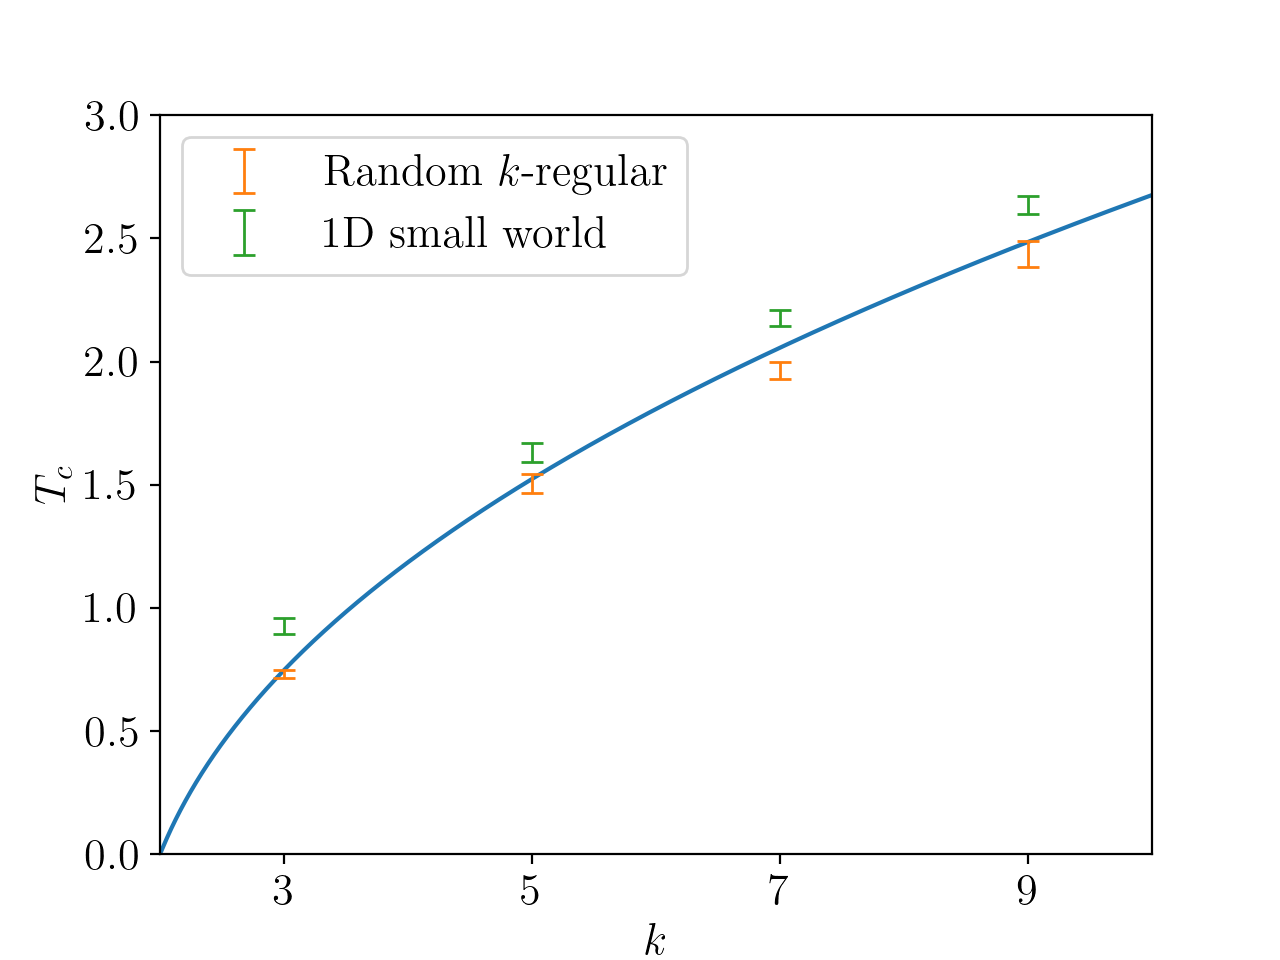

In [25]:
# %% RRG and 1D vs theory
Tc_x = np.linspace(0, 3, 10000)
x = np.linspace(-100, 100, 10000)
k = np.zeros([len(Tc_x)])
for i, Tc in enumerate(Tc_x):
    y = np.tanh(x / Tc) ** 2 * np.exp(-0.5 * (x ** 2)) / np.sqrt(2 * np.pi)
    k[i] = 1 / np.trapz(y, x)

fig, ax = plt.subplots(dpi=200)
ax.plot(k + 1, Tc_x)
ax.errorbar(np.array([3, 5, 7, 9]), Tc_inf_vs_adj[:4], Tc_inf_err_vs_adj[:4], label='Random $k$-regular', markerfacecolor="None", capsize=4, capthick=1,
                 elinewidth=1, linewidth=0)
ax.errorbar(np.array([3, 5, 7, 9]), Tc_inf_vs_adj[4:8], Tc_inf_err_vs_adj[4:8], label='1D small world', markerfacecolor="None", capsize=4, capthick=1,
                 elinewidth=1, linewidth=0)

ax.set_xticks([3, 5, 7, 9])
ks = [np.abs(k+1-ki).argmin() for ki in [3, 5, 7, 9]]
print(Tc_x[ks])

ax.set_xlim([2, 10])
ax.set_ylim([0, 3])
ax.legend()
ax.set_xlabel('$k$')
ax.set_ylabel('$T_c$')
figs.export(f'Random-regular and small-world vs theory.pdf')

# [Fig. 6] Tc vs adjacency: D-Wave

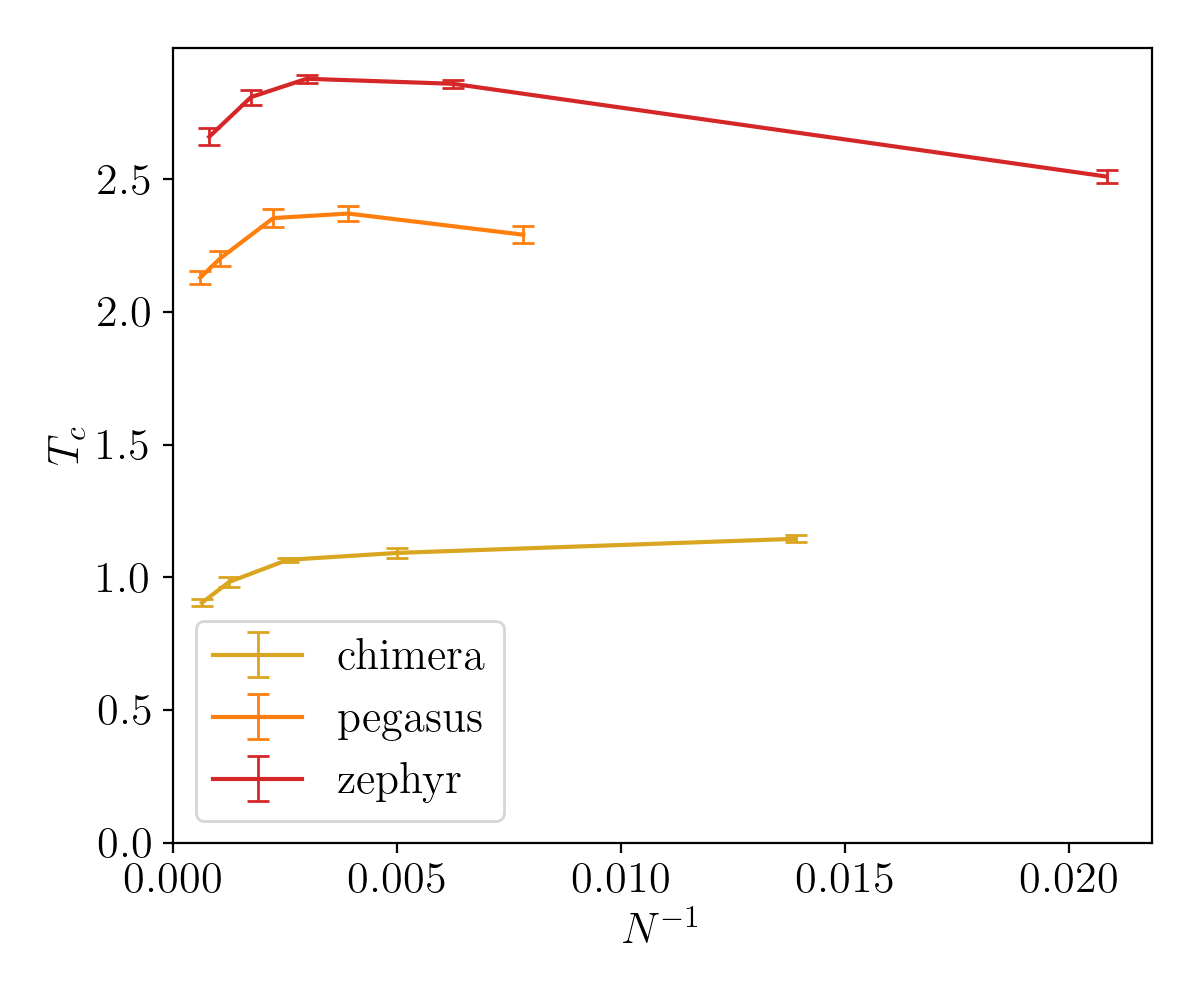

In [244]:
fig, ax1 = plt.subplots(figsize=[6,5])

for adj_index in range(len(adjacencies)-3, len(adjacencies)):
    ax1.errorbar(1/np.array(sizes_vs_adj[adj_index]), Tc_vs_adj[adj_index], yerr=Tc_err_vs_adj[adj_index],
                 label=rf'{adjacencies[adj_index]}', color=color_vs_adj[adj_index], markersize=3, capsize=4, capthick=1,elinewidth=1)

ax1.legend()
ax1.set_ylabel('$T_c$')
ax1.set_xlabel(r'$N^{-1}$')
ax1.set_ylim(bottom=0)
ax1.set_xlim(left=0)
fig.tight_layout()

figs.export(f'Tc_vs_adjacency_Dwave.pdf')

# [Figs. 7, 8 and 13] Autocorrelation times

In [247]:
# Load data for autocorrelation time plots
adj_indices = [0, 8, 9, 10]
fname = f'Processed_Data/Autocorrelation_times_adjacencies={adj_indices}.npz'
data = np.load(fname, allow_pickle=True)
T_tau_vs_adj = data['T_tau_vs_adj']
T_fit_tau_vs_adj = data['T_fit_tau_vs_adj']
log_tau_vs_adj = data['log_tau_vs_adj']
log_tau_fit_vs_adj = data['log_tau_fit_vs_adj']
log_tau_specific_vs_adj = data['log_tau_specific_vs_adj']
log_tau_specific_fit_vs_adj = data['log_tau_specific_fit_vs_adj']
T_for_tau_vs_size = data['T_for_tau_vs_size']
log_tau_vs_size_for_specific_T_vs_adj = data['log_tau_vs_size_for_specific_T_vs_adj']
power_scaling_params_log_tau_vs_size_for_specific_T_vs_adj = \
    data['power_scaling_params_log_tau_vs_size_for_specific_T_vs_adj']
exp_scaling_params_log_tau_vs_size_for_specific_T_vs_adj = \
    data['exp_scaling_params_log_tau_vs_size_for_specific_T_vs_adj']
start_range_vs_adj = data['start_range_vs_adj']
end_range_vs_adj = data['end_range_vs_adj']

## [Fig. 7]

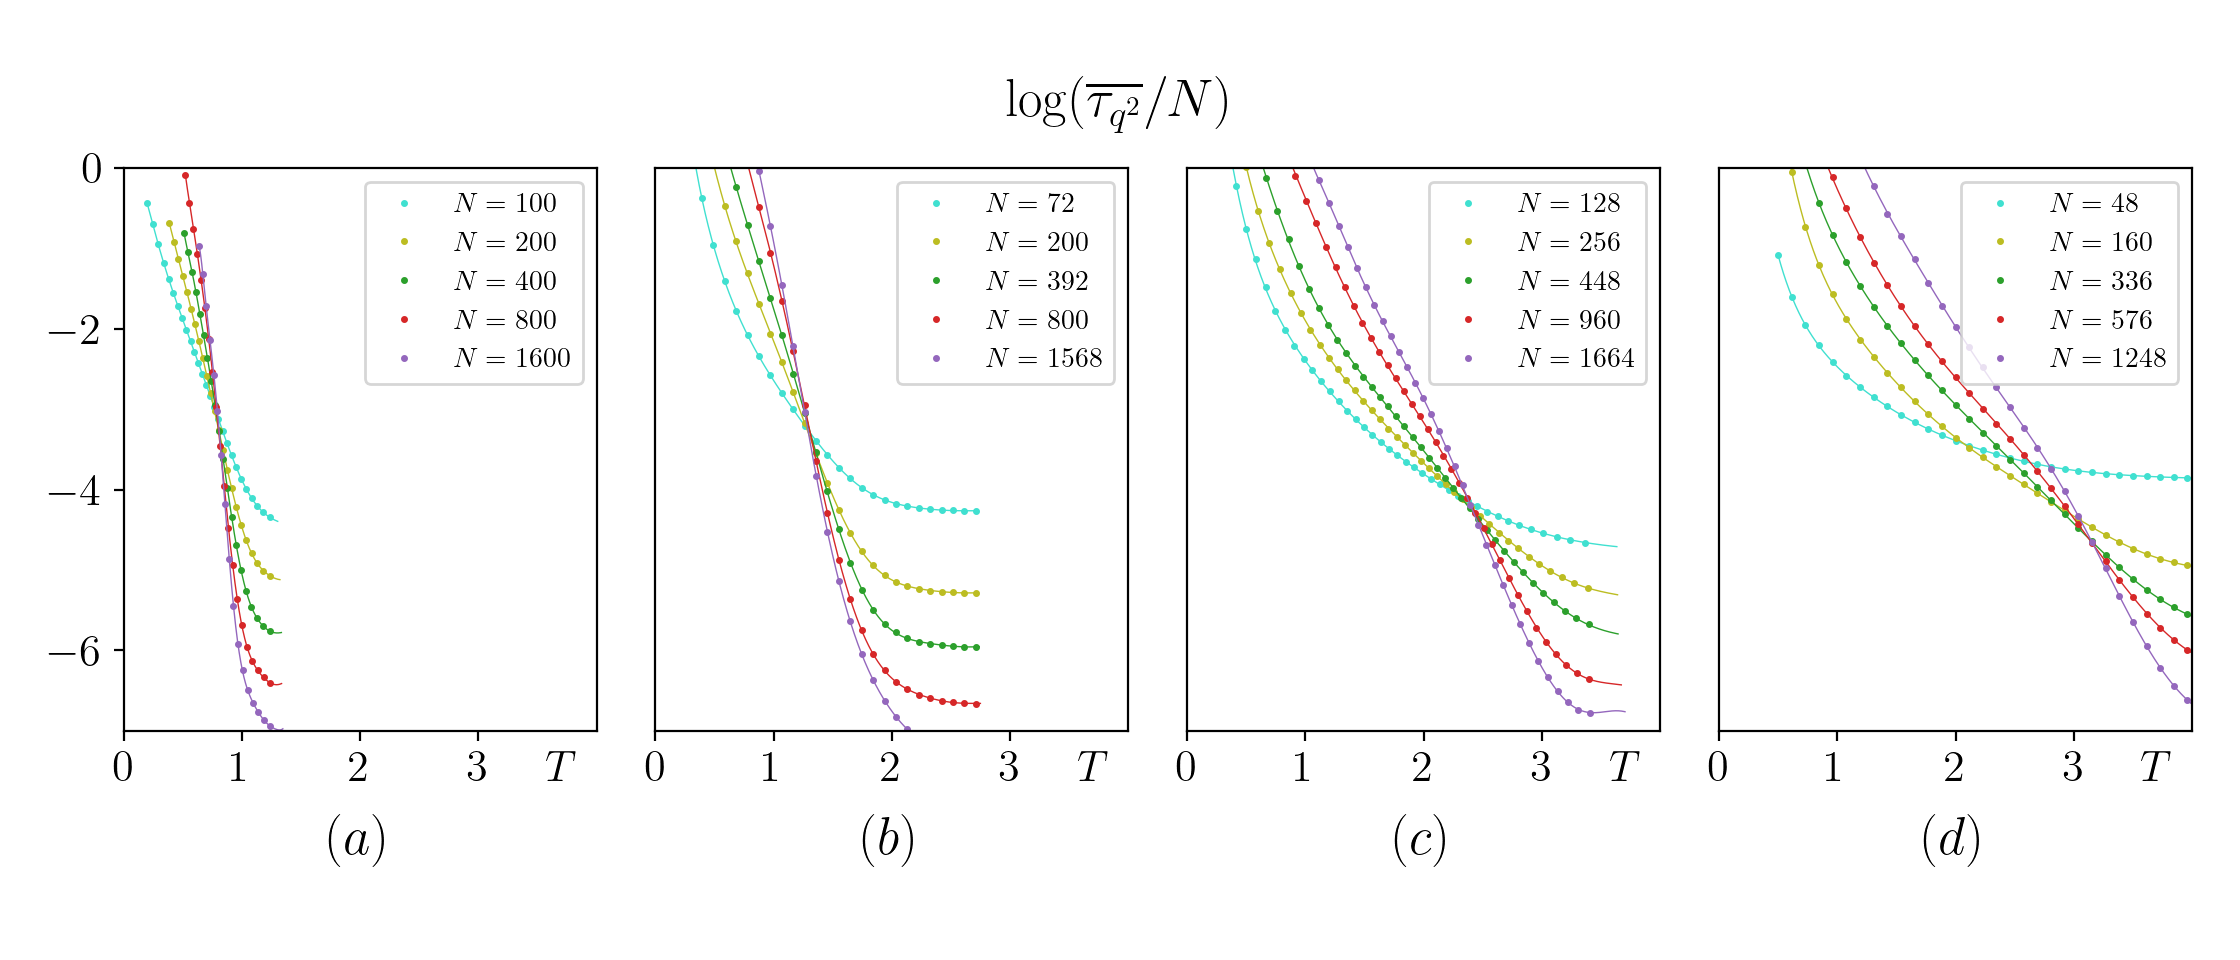

In [251]:
# Plot autocorrelation time
adjacency_names = ['$(a)$', '$(b)$', '$(c)$', '$(d)$']
fig, ax = plt.subplots(ncols=4, figsize=[4*4*0.7, 4*1.2])
for adj_iterable, adj_index in enumerate(adj_indices):
    for size_index in range(len(sizes)):
        if i==3 and size_index == 0:
            continue
        ax[adj_iterable].plot(T_tau_vs_adj[adj_iterable][size_index][:-3], log_tau_specific_vs_adj[adj_iterable][size_index][:-3],
                   color=color_vs_size[size_index], marker='.', linewidth=0, markersize=3, label=f'$N={sizes_vs_adj[adj_index][size_index]}$')
        ax[adj_iterable].plot(T_fit_tau_vs_adj[adj_iterable][size_index][:-100], log_tau_specific_fit_vs_adj[adj_iterable][size_index][:-100], color=color_vs_size[size_index], linewidth=0.5)

    ax[adj_iterable].set_title(f'{adjacency_names[adj_iterable]}', y=-.25)
    ax[adj_iterable].set_xlabel('$T$')
    ax[adj_iterable].set_ylim(-7, 0)
    ax[adj_iterable].set_xlim(0,4)
    ax[adj_iterable].set_xticks([0,1,2,3 ])
    ax[adj_iterable].xaxis.set_label_coords(0.92, -0.035)

    if adj_iterable > 0:
        ax[adj_iterable].set_yticks([])
    ax[adj_iterable].legend(fontsize=10, loc='upper right')

    fig.suptitle(r'$\log(\overline{\tau_{q^2}}/N)$', y=0.92)

fig.tight_layout()
figs.export('specific autocorrelation times for rrg3 and DWave.pdf')

## [Fig. 13]

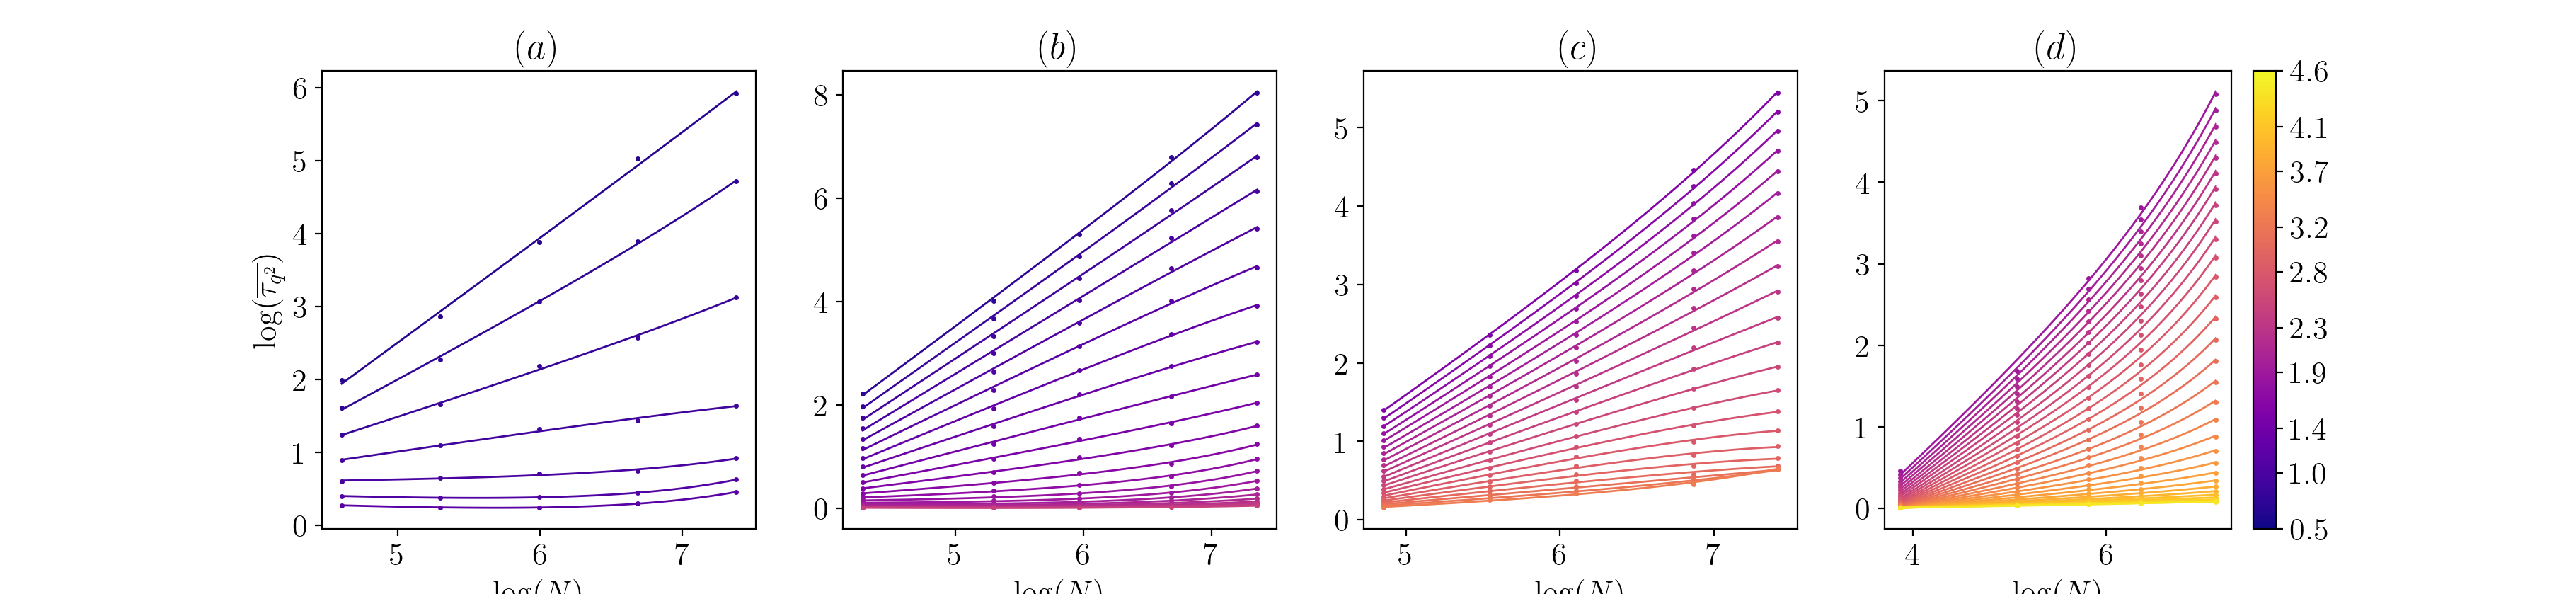

In [252]:
# Plot autocorrelation time vs size for different temperatures
scaling_law_type = 'exp'
# scaling_law_type = 'power'

def power_scaling(x, a, c):
    return a*x + c
def exp_scaling(x, a, b, c):
    return a*x + b*np.exp(x) + c

if scaling_law_type == 'power':
    scaling_law = power_scaling
    scaling_params = power_scaling_params_log_tau_vs_size_for_specific_T_vs_adj
elif scaling_law_type == 'exp':
    scaling_law = exp_scaling
    scaling_params = exp_scaling_params_log_tau_vs_size_for_specific_T_vs_adj

colors_autocorrelation = plt.get_cmap('plasma')(np.linspace(0, 255, len(T_for_tau_vs_size)).astype('int'))
fig, ax = plt.subplots(ncols=len(adj_indices), figsize=[26*0.7, 6*0.7])
adjacency_names = ['$(a)$', '$(b)$', '$(c)$', '$(d)$']

for adj_iterable, adj_index in enumerate(adj_indices):
    for T_fit_index, T in enumerate(T_for_tau_vs_size[::10]):
        T_fit_index *=10

        if start_range_vs_adj[adj_iterable]<T_fit_index<end_range_vs_adj[adj_iterable] :

            log_tau_vs_size = log_tau_vs_size_for_specific_T_vs_adj[adj_iterable][T_fit_index]
            ax[adj_iterable].plot(np.log(sizes_vs_adj[adj_index]), log_tau_vs_size, color=colors_autocorrelation[T_fit_index],
                       linewidth=0, marker='.', markersize=3)

            non_thermalized_index = np.where(~np.isnan(log_tau_vs_size))[0][-1]
            N0 = np.log(sizes_vs_adj[adj_index][:non_thermalized_index+1])[0]
            Nf = np.log(sizes_vs_adj[adj_index][:non_thermalized_index+1])[-1]
            sizes_fit= np.linspace(N0, Nf, 100)
            ax[adj_iterable].plot(sizes_fit, scaling_law(sizes_fit, *scaling_params[adj_iterable][T_fit_index]), color=colors_autocorrelation[T_fit_index], linewidth=1)


    ax[adj_iterable].set_title(f'{adjacency_names[adj_iterable]}')
    ax[adj_iterable].set_xlabel(r'$\log(N)$')

ax[0].set_ylabel(r'$\log(\overline{\tau_{q^2}})$')

figs.colorbar_for_lines(fig, T_for_tau_vs_size[::50].round(1))

## [Fig. 8]

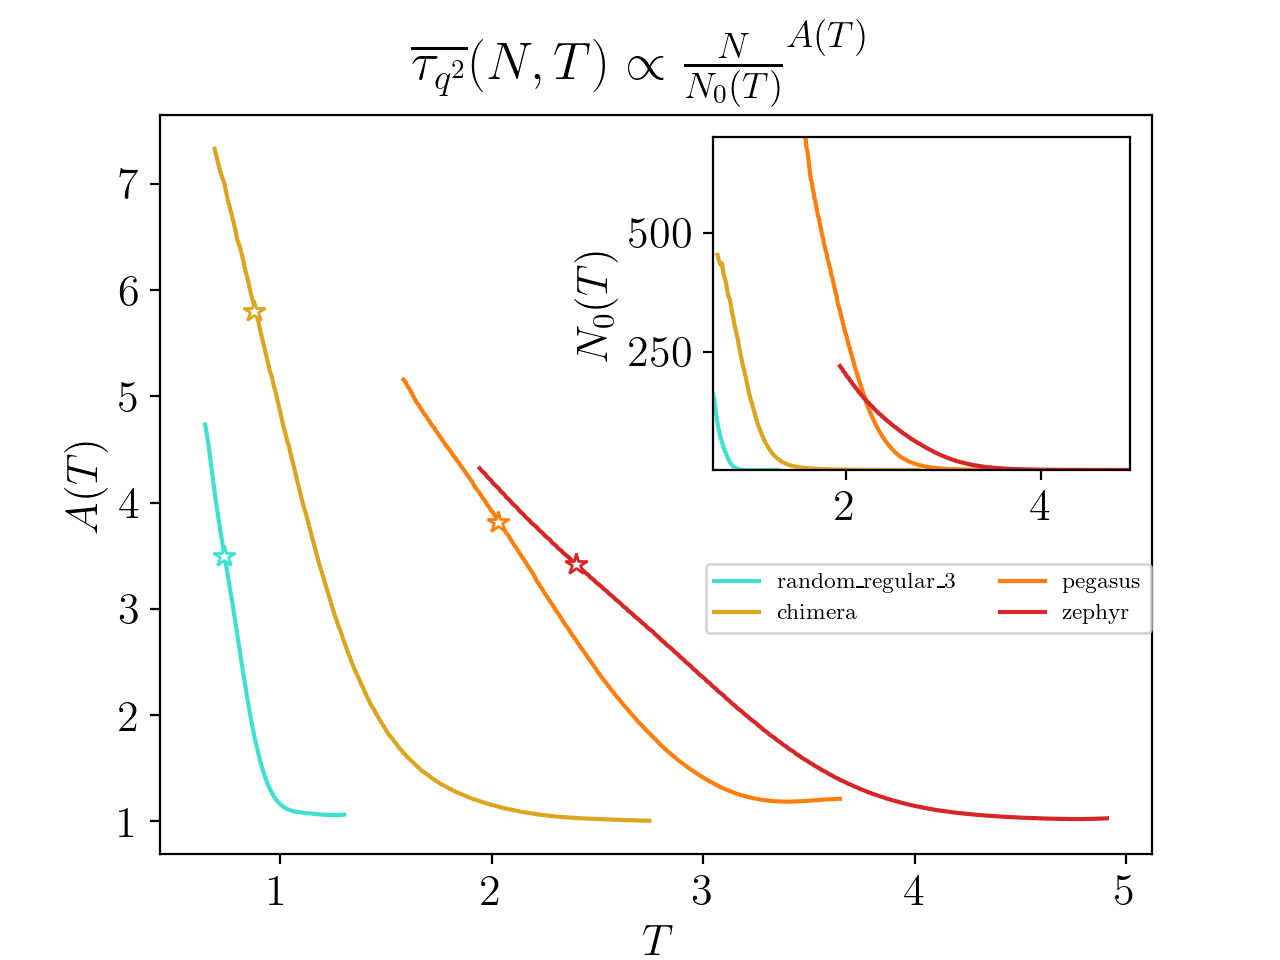

In [253]:
Tc_vs_adj = [0.733, 0.876, 2.029, 2.400]
height_vs_adj = [3.5, 5.8, 3.82, 3.42]

fig, ax = plt.subplots()
axins = inset_axes(ax, width="42%", height="45%", loc=1)

for adj_iterable, adj_index in enumerate(adj_indices):
    scaling_params = power_scaling_params_log_tau_vs_size_for_specific_T_vs_adj[adj_iterable]
    scaling_params[scaling_params == 0] = np.nan
    ax.plot(T_for_tau_vs_size[start_range_vs_adj[adj_iterable]:end_range_vs_adj[adj_iterable]],
            np.exp(scaling_params[:, 0])[start_range_vs_adj[adj_iterable]:end_range_vs_adj[adj_iterable]], color=color_vs_adj[adj_index],
            label=f'{adjacencies[adj_index]}')
    ax.plot([Tc_vs_adj[adj_iterable]], [height_vs_adj[adj_iterable]], marker='*', markerfacecolor='w', color=color_vs_adj[adj_index],
            markersize='8')
    axins.plot(T_for_tau_vs_size[start_range_vs_adj[adj_iterable]:end_range_vs_adj[adj_iterable]],
               1 / np.exp(scaling_params[:, 1])[start_range_vs_adj[adj_iterable]:end_range_vs_adj[adj_iterable]], color=color_vs_adj[adj_index])

ax.legend(fontsize=8, ncols=2, loc=(0.55, 0.3))
axins.set_ylabel('$N_0(T)$')
fig.suptitle(r'$ \overline{\tau_{q^2}}(N,T) \propto \frac{N}{N_0(T)}^{A(T)}$')
ax.set_ylabel(r'$A(T)$')
ax.set_xlabel(r'$T$')
figs.export('power scaling autocorrelation time.pdf')